# 1-0. Import

In [256]:
import os.path as osp
import openslide
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.filters import threshold_otsu

from openslide.deepzoom import DeepZoomGenerator

import cv2
from keras.utils.np_utils import to_categorical

# network

from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

# train

from sklearn.model_selection import StratifiedShuffleSplit
from datetime import datetime

# evaluate

import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# 1-1. Data Load

In [79]:
slide_path = 'data/train/image/positive/Slide001.mrxs'
slide = openslide.open_slide(slide_path)

BASE_TRUTH_DIR = Path('data/train/mask')
truth_path = str(BASE_TRUTH_DIR/'positive/Slide001.png')
truth = openslide.open_slide(truth_path)

print("original slide dimensions %dx%d" % slide.dimensions)
print("original truth dimensions %dx%d" % truth.dimensions)

original slide dimensions 93970x234042
original truth dimensions 5316x10007


# 1-2. Fit Data Shape

- 밑에 a, b 괄호친 부분은 csv 파일 읽고 min_x, min_y 넣어야함

- https://openslide.org/api/python/#module-openslide


In [115]:
a = 7744  # min x offset  
b = 39056   # min y offset
start = (int(a),int(b)) 
c, d = (truth.dimensions[0]/16,truth.dimensions[1]/16)
size = (int(c),int(d))
slide4 = slide.read_region(start,8,size) # 3초 #read_region(location, level, size)

## Check if works

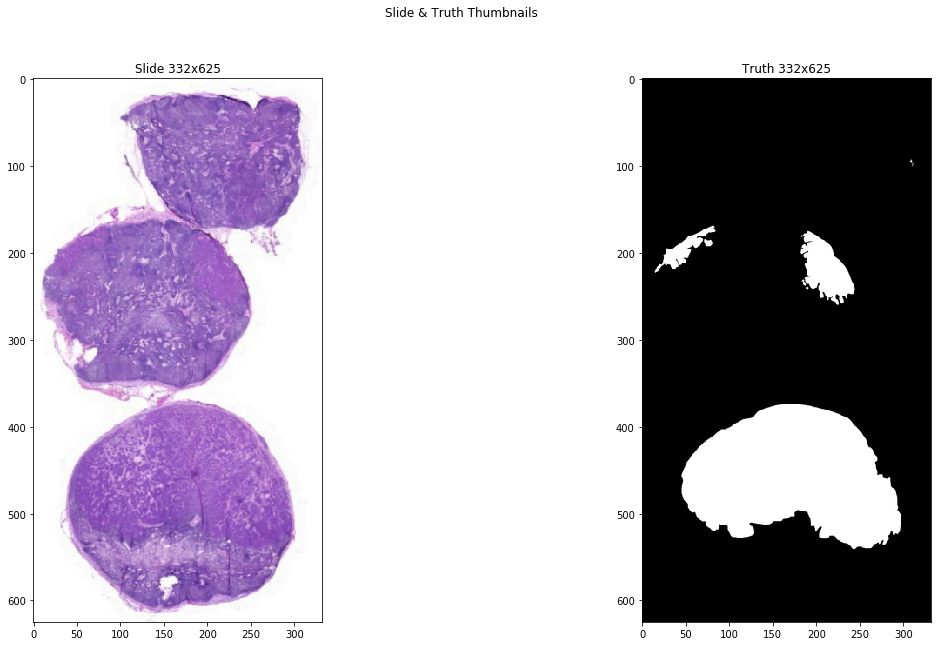

In [118]:
thumbnail_truth = truth.get_thumbnail((truth.dimensions[0]/16 , truth.dimensions[1]/16 )) 

f, axes = plt.subplots(1, 2, figsize=(20, 10));
ax = axes.ravel()
ax[0].imshow(slide4);
ax[0].set_title('Slide %dx%d' % slide4.size)
ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
ax[1].set_title('Truth %dx%d' % thumbnail_truth.size)
f.suptitle('Slide & Truth Thumbnails ');

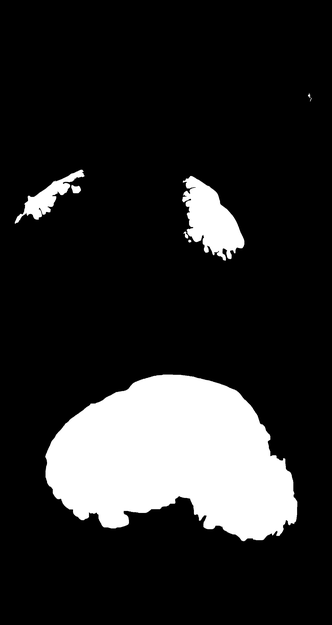

In [146]:
thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / 16, truth.dimensions[1] / 16)) 

thumbnail_truth.convert("L")

In [237]:
#slide4 = slide.read_region(start,8,size) # 3초 #read_region(location, level, size)
slide4.size

(332, 625)

In [291]:
m = np.array(slide4.convert("L"))
m.size

207500

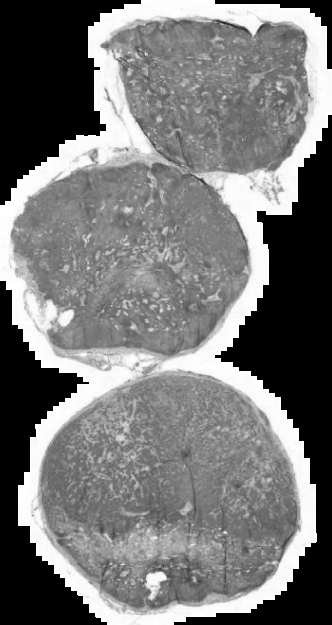

In [315]:
slide4.convert("L")

In [240]:
b= np.array(slide4.convert("L"))>0

In [307]:
thumbnail_grey = np.array(slide4.convert('L'))
thresh = threshold_otsu(thumbnail_grey)
binary = thumbnail_grey > thresh

patches = pd.DataFrame(pd.DataFrame(binary).stack())
patches['is_tissue'] = ~patches[0]
patches.drop(0, axis=1, inplace=True)
patches['slide_path'] = slide_path

In [314]:
len(patches[patches['is_tissue']==0])
len(binary[binary>0])
len(b[b>0])
len(b[b==0])
k =b[b==0]
k[2]
a = np.array(thumbnail_truth.convert("L"))>0
len(a[a>0])

151213

In [160]:
patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
patches_y['is_tumor'] = patches_y[0] > 0
patches_y.drop(0, axis=1, inplace=True)

# 1-3 Patch Gen

- get_thumbnail(size)
: Return an Image containing an RGB thumbnail of the slide.
- patch size 만큼 dimensions 나누기. 1 픽셀이 하나의 패치가 됨 -> DeepZoomGenerator로 다시 확대가능 (patch_size만큼) (2의 거듭제곱으로)
- tissue 검사 - patch['is_tissue'] : ostu method
- tumor 검사 - patch['is_tummor'] 라벨 : mask로 구분
- 경로 추가 저장 = patch['slide_path']
- 최종 training set = concat[patch, patch_y]

In [120]:
PATCH_SIZE = 256
IS_TRAIN = True

In [316]:
def find_patches_from_slide(slide_path, base_truth_dir=BASE_TRUTH_DIR,patch_size=PATCH_SIZE,filter_non_tissue=True):
    """Returns a dataframe of all patches in slide
    input: slide_path: path to WSI file
    output: samples: dataframe with the following columns:
        slide_path: path of slide
        is_tissue: sample contains tissue
        is_tumor: truth status of sample
        tile_loc: coordinates of samples in slide
        
    
    option: base_truth_dir: directory of truth slides
    option: filter_non_tissue: Remove samples no tissue detected
    option: patch_size: patch_size
    slide_contains_tumor true -> taking the label from mask png
    """
    slide_contains_tumor = 'pos' in slide_path
     
    base_truth_dir = Path(base_truth_dir)
    truth_path = str(base_truth_dir/'positive/Slide001.png')
    truth = openslide.open_slide(truth_path)
    
    div = patch_size/16
    level = np.log2(patch_size)
    level = int(level)
    a,b = (7744,39056)   # min x offset,min y offset
    start = (int(a),int(b)) 
    c, d = (truth.dimensions[0]/16,truth.dimensions[1]/16)
    size = (int(c),int(d))
     
    with openslide.open_slide(slide_path) as slide:
        thumbnail = slide.read_region(start,level,size)
    print('type thumbnail, ',type(thumbnail))
    
    thumbnail_grey = np.array(thumbnail.convert('L')) # convert to grayscale # 흰색은 = 0 값을 가지게 됨. # 0.1~10정도 #나중에 또 찍어보자
    #  thresh = threshold_ostu(thumbnail_grey)
    binary = (thumbnail_grey) > 0
   
    patches = pd.DataFrame(pd.DataFrame(binary).stack())
    patches['is_tissue'] = patches[0]
    patches.drop(0, axis=1, inplace=True)
    patches['slide_path'] = slide_path
    
    print('patches.tissue.size : ', len(patches.is_tissue>0))
    if slide_contains_tumor:
        thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / int(div), truth.dimensions[1] / int(div))) 
        print('type thumbnail_truth, ',type(thumbnail_truth))
        patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0
        patches_y.drop(0, axis=1, inplace=True)
        samples = pd.concat([patches, patches_y], axis=1)
    else:
        samples = patches
        samples['is_tumor'] = False
    
    if filter_non_tissue:
        samples = samples[samples.is_tissue == True] # remove patches with no tissue
        
    samples['tile_loc'] = list(samples.index)
    samples.reset_index(inplace=True, drop=True)
    
    return samples

## Check if works

In [317]:
all_tissue_samples = find_patches_from_slide(slide_path)
print('Total patches in slide: %d' % len(all_tissue_samples))
all_tissue_samples.iloc[:10]
all_tissue_samples.is_tumor.value_counts()

type thumbnail,  <class 'PIL.Image.Image'>
patches.tissue.size :  207500
type thumbnail_truth,  <class 'PIL.Image.Image'>
Total patches in slide: 151503


False    116324
True      35179
Name: is_tumor, dtype: int64

In [294]:
# 비율도 통계로 내려봐야할듯 나중에 샘플링할때 

In [318]:
all_tissue_samples.is_tissue.value_counts()

True    151503
Name: is_tissue, dtype: int64

In [320]:
all_tissue_samples[all_tissue_samples.is_tumor>0].iloc[:10]

,is_tissue,slide_path,is_tumor,tile_loc
20652,True,data/train/image/positive/Slide001.mrxs,True,"(92, 308)"
20653,True,data/train/image/positive/Slide001.mrxs,True,"(92, 309)"
20654,True,data/train/image/positive/Slide001.mrxs,True,"(92, 310)"
20888,True,data/train/image/positive/Slide001.mrxs,True,"(93, 306)"
20890,True,data/train/image/positive/Slide001.mrxs,True,"(93, 308)"
20891,True,data/train/image/positive/Slide001.mrxs,True,"(93, 309)"
20893,True,data/train/image/positive/Slide001.mrxs,True,"(93, 311)"
21126,True,data/train/image/positive/Slide001.mrxs,True,"(94, 306)"
21127,True,data/train/image/positive/Slide001.mrxs,True,"(94, 307)"
21128,True,data/train/image/positive/Slide001.mrxs,True,"(94, 308)"


In [324]:
thumbnail = slide.read_region(start,8,size)

In [327]:
type(tiles)

openslide.deepzoom.DeepZoomGenerator

In [331]:
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
tiles_truth = DeepZoomGenerator(truth, tile_size=16, overlap=0, limit_bounds=False)

AttributeError: 'Image' object has no attribute 'level_dimensions'

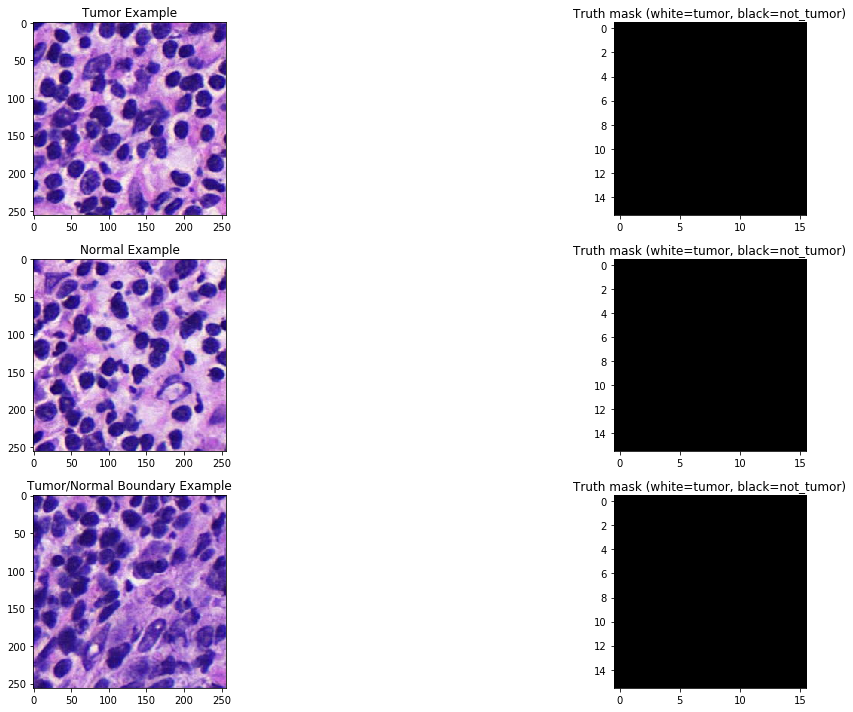

In [338]:
f, axes = plt.subplots(3, 2, figsize=(20, 10))
axes[0, 0].imshow(tiles.get_tile(tiles.level_count-1, (31+92, 153+308)));
axes[0, 0].set_title('Tumor Example');
axes[0, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1,(95, 309)));
axes[0, 1].set_title('Truth mask (white=tumor, black=not_tumor)')
axes[1, 0].imshow(tiles.get_tile(tiles.level_count-1, (31+94, 153+307)));
axes[1, 0].set_title('Normal Example');
axes[1, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1, (94, 307)));
axes[1, 1].set_title('Truth mask (white=tumor, black=not_tumor)')
axes[2, 0].imshow(tiles.get_tile(tiles.level_count-1, (31+97, 153+308)));
axes[2, 0].set_title('Tumor/Normal Boundary Example');
axes[2, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1, (97, 308)));
axes[2, 1].set_title('Truth mask (white=tumor, black=not_tumor)');
plt.tight_layout();

In [332]:
tiles_truth.level_count-1

14

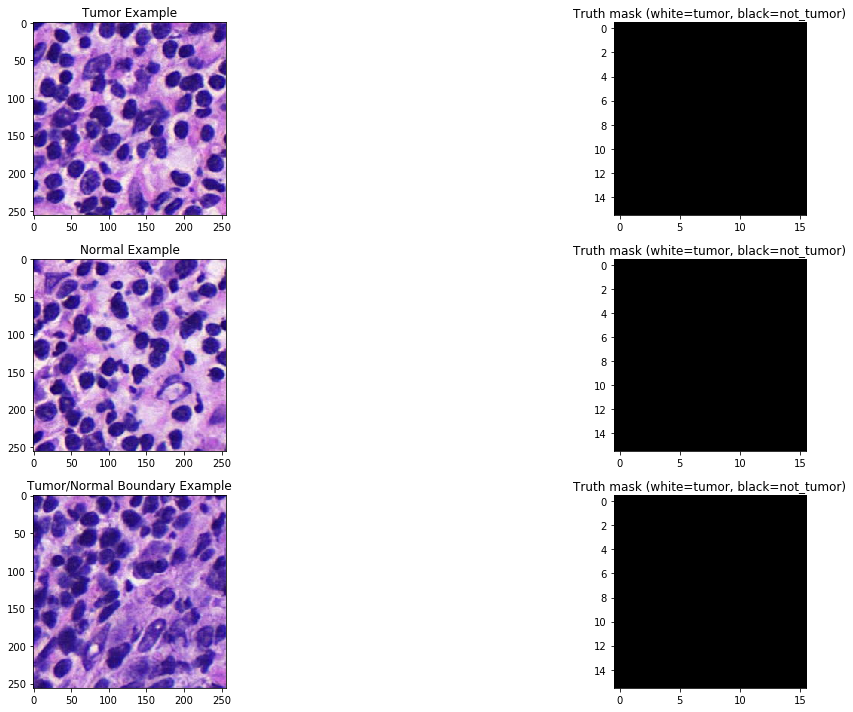

In [330]:
f, axes = plt.subplots(3, 2, figsize=(20, 10))
axes[0, 0].imshow(tiles.get_tile(tiles.level_count-1, (31+92, 153+308)));
axes[0, 0].set_title('Tumor Example');
axes[0, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1,(92, 308)));
axes[0, 1].set_title('Truth mask (white=tumor, black=not_tumor)')
axes[1, 0].imshow(tiles.get_tile(tiles.level_count-1, (31+94, 153+307)));
axes[1, 0].set_title('Normal Example');
axes[1, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1, (94, 307)));
axes[1, 1].set_title('Truth mask (white=tumor, black=not_tumor)')
axes[2, 0].imshow(tiles.get_tile(tiles.level_count-1, (31+97, 153+308)));
axes[2, 0].set_title('Tumor/Normal Boundary Example');
axes[2, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1, (97, 308)));
axes[2, 1].set_title('Truth mask (white=tumor, black=not_tumor)');
plt.tight_layout();

# 1-4. Train data Gen

In [297]:
NUM_CLASSES = 2 # not_tumor, tumor

def gen_imgs(samples, batch_size, base_truth_dir=BASE_TRUTH_DIR, shuffle=True):
    """This function returns a generator that 
    yields tuples of (
        X: tensor, float - [batch_size, 256, 256, 3]
        y: tensor, int32 - [batch_size, 256, 256, NUM_CLASSES]
    )
    
    
    input: samples: samples dataframe
    input: batch_size: The number of images to return for each pull
    output: yield (X_train, y_train): generator of X, y tensors
    
    option: base_truth_dir: path, directory of truth slides
    option: shuffle: bool, if True shuffle samples
    """
    
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
        
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows():
                slide_contains_tumor = 'pos' in slide_path
                
                with openslide.open_slide(batch_sample.slide_path) as slide:
                     tiles = slide.read_region(start,8 ,size) # 이부분도 patch_size에 맞게 수정해야함
                    #tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
                    
                    # 여기서 틀렸네
                    img = tiles.get_tile(tiles.level_count-1, batch_sample.tile_loc[::-1])
                    
                # only load truth mask for tumor slides
                if slide_contains_tumor:
                    truth_path = str(base_truth_dir/'positive/Slide001.png')
                    with openslide.open_slide(truth_path) as truth:
                        truth_tiles = DeepZoomGenerator(truth, tile_size=16, overlap=0, limit_bounds=False)
                        mask = truth_tiles.get_tile(truth_tiles.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                else:
                    mask = np.zeros((256, 256))

                images.append(np.array(img))
                masks.append(mask)

            X_train = np.array(images)
            y_train = np.array(masks)
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], 256, 256, 2)
            yield X_train, y_train

In [298]:
sample_gen = gen_imgs(all_tissue_samples.sample(128, random_state=156), 128, shuffle=False)
%time example_X, example_y  = next(sample_gen)

Wall time: 16 s


In [279]:
%time example_X, example_y  = next(sample_gen)

Wall time: 15.9 s


## Check if right

In [299]:
example_X.shape

(128, 256, 256, 3)

In [300]:
example_y.shape

(128, 256, 256, 2)

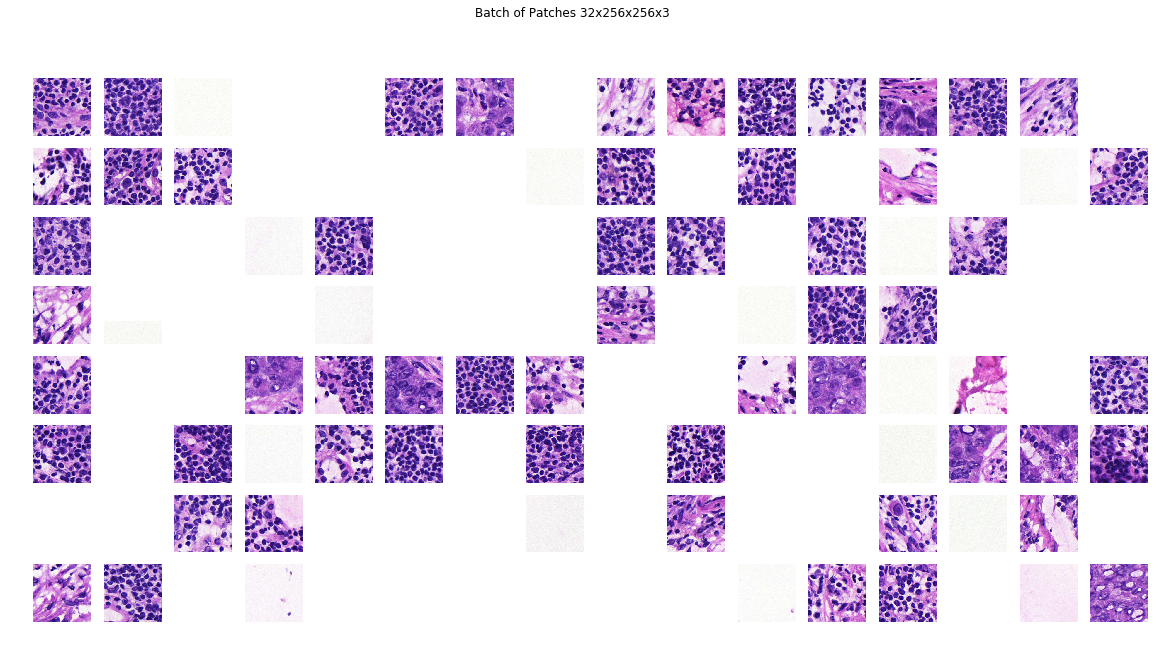

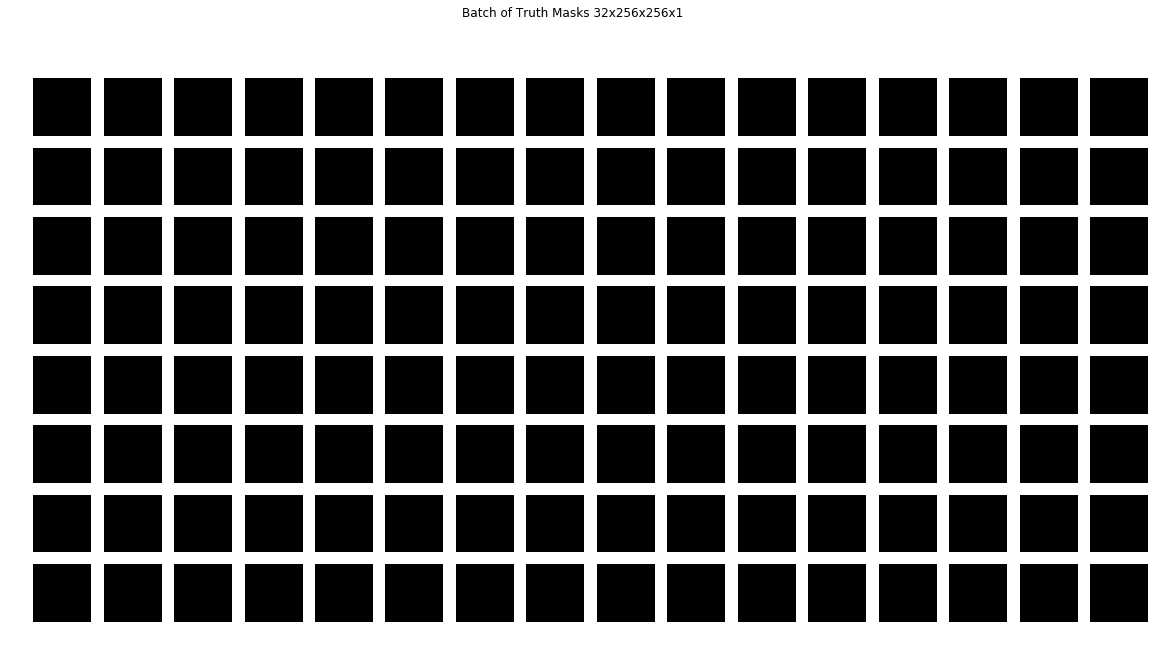

In [301]:
f, axes = plt.subplots(8,16, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_X[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(8, 16, figsize=(20, 10));
ax = axes.flatten()    
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');